# Getting Started with Keras

## Introduction to Keras for Researchers

In [6]:
import tensorflow as tf

a = tf.random.normal((2, 2))
b = tf.random.normal((2, 2))

print(a)

tf.Tensor(
[[ 0.48220563 -0.0322735 ]
 [-0.767051   -0.03137907]], shape=(2, 2), dtype=float32)


In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from tensorflow import keras

In [9]:
class Linear(keras.layers.Layer):
    """y = w.x + b"""

    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


# Instantiate our lazy layer.
linear_layer = Linear(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(tf.ones((2, 2)))

In [10]:
# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate our linear layer (defined above) with 10 units.
linear_layer = Linear(10)

# Instantiate a logistic loss function that expects integer targets.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):

    # Open a GradientTape.
    with tf.GradientTape() as tape:

        # Forward pass.
        logits = linear_layer(x)

        # Loss value for this batch.
        loss = loss_fn(y, logits)

    # Get gradients of the loss wrt the weights.
    gradients = tape.gradient(loss, linear_layer.trainable_weights)

    # Update the weights of our linear layer.
    optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

    # Logging.
    if step % 100 == 0:
        print("Step:", step, "Loss:", float(loss))

11490434/11490434 [==============================] - 1s 0us/step
Step: 0 Loss: 2.495600700378418
Step: 100 Loss: 2.26900053024292
Step: 200 Loss: 2.1745779514312744
Step: 300 Loss: 2.1358487606048584
Step: 400 Loss: 1.9734742641448975
Step: 500 Loss: 1.9851772785186768
Step: 600 Loss: 1.7503931522369385
Step: 700 Loss: 1.8720858097076416
Step: 800 Loss: 1.7432726621627808
Step: 900 Loss: 1.7420308589935303


In [13]:
type(gradients[1])

tensorflow.python.framework.ops.EagerTensor

In [14]:
class ActivityRegularization(keras.layers.Layer):
    """Layer that creates an activity sparsity regularization loss."""

    def __init__(self, rate=1e-2):
        super(ActivityRegularization, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs


class SparseMLP(keras.layers.Layer):
    """Stack of Linear layers with a sparsity regularization loss."""

    def __init__(self):
        super(SparseMLP, self).__init__()
        self.linear_1 = Linear(32)
        self.regularization = ActivityRegularization(1e-2)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.regularization(x)
        return self.linear_3(x)


mlp = SparseMLP()

In [19]:
y = mlp(tf.ones((10, 10)))
print(mlp.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.22572844>]


In [20]:
y = mlp(tf.ones((10, 10)))
print(mlp.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.22572844>]


In [25]:
x = tf.constant([1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.1, 0, -0.1], dtype=tf.float32)
x1 = tf.greater_equal(x, 0.4)

In [26]:
tf.cast(x1, tf.bool)

<tf.Tensor: shape=(9,), dtype=bool, numpy=array([ True,  True,  True,  True,  True,  True, False, False, False])>

In [27]:
x1

<tf.Tensor: shape=(9,), dtype=bool, numpy=array([ True,  True,  True,  True,  True,  True, False, False, False])>

In [29]:
for i in zip([1, 2], [3, 4]):
    print(i)

(1, 3)
(2, 4)


## Save Models

In [4]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

In [7]:
inputs = keras.Input(shape=(784,), name="digits")
x = keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(10, name="predictions")(x)
functional_model = keras.Model(inputs=inputs, outputs=outputs, name="3_layer_mlp")

# Extract a portion of the functional model defined in the Setup section.
# The following lines produce a new model that excludes the final output
# layer of the functional model.
pretrained = keras.Model(
    functional_model.inputs, functional_model.layers[-1].input, name="pretrained_model"
)
# Randomly assign "trained" weights.
for w in pretrained.weights:
    w.assign(tf.random.normal(w.shape))
pretrained.save_weights("pretrained_ckpt")

# Assume this is a separate program where only 'pretrained_ckpt' exists.
# Create a new functional model with a different output dimension.
inputs = keras.Input(shape=(784,), name="digits")
x = keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(5, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="new_model")

# Load the weights from pretrained_ckpt into model.
model.load_weights("pretrained_ckpt")

# Check that all of the pretrained weights have been loaded.
for a, b in zip(pretrained.weights, model.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())

None
None
None
None


In [15]:
tf.random.experimental.stateless_split([1, 1], num=1)[0, :]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([-510880680, -518913937])>

In [17]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a)

[[1 2 3]
 [4 5 6]]


In [18]:
a.shape

(2, 3)

In [19]:
a[0]

array([1, 2, 3])

In [21]:
a[1]

array([4, 5, 6])

-----

## Dataset

In [1]:
from glob import glob

import tensorflow as tf
import cv2
import numpy as np
import pandas as pd

In [2]:
image_dir = "../../Dataset/training_2D/training/segmentation_set/img"
image_type = "png"
mask_dir = "../../Dataset/training_2D/training/segmentation_set/seg"
mask_type = "png"

In [3]:
image_array = ["../../Dataset/training_2D/training/segmentation_set/img/Sample000001.png",
               "../../Dataset/training_2D/training/segmentation_set/img/Sample000002.png",
               "../../Dataset/training_2D/training/segmentation_set/seg/Sample000001.png"]

In [12]:
def load_an_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = tf.convert_to_tensor(image, dtype=tf.int8)
    image = tf.expand_dims(image, axis=-1)
    return image


def resize_and_rescale(image, target_size):
    if image.shape[0] < target_size[0] or image.shape[1] < target_size[1]:
        image = tf.image.resize_with_crop_or_pad(image, target_height=target_size[0], target_width=target_size[1])
    else:
        image = tf.image.resize(image, size=target_size)

    image = image / 255.0
    return image

In [13]:
img0 = load_an_image(image_array[0])
img1 = load_an_image(image_array[1])

In [14]:
img_concat = tf.concat([img0, img1], axis=-1)
print(img_concat.shape)

(520, 696, 2)


In [15]:
img_resized = resize_and_rescale(img_concat, (520, 520))
print(img_resized.shape)

(520, 520, 2)


In [ ]:
img = cv2.imread(image_array[0])
cv2.imshow("1", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
from draft import *

76
(256, 256)


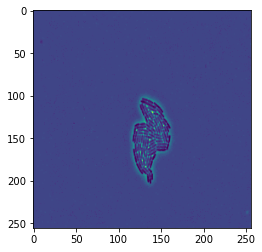

In [5]:
SEED = 1
IMG_SIZE = 256
BATCH_SIZE = 4

# Training_2D
image_dir = "../../Dataset/training_2D/training/segmentation_set/img"
image_type = "png"
mask_dir = "../../Dataset/training_2D/training/segmentation_set/seg"
mask_type = "png"

data_gen = DataGenerator(batch_size=BATCH_SIZE, dataset="training_2d",
                         image_dir=image_dir, image_type=image_type,
                         mask_dir=mask_dir, mask_type=mask_type,
                         target_size=(256, 256), transforms=None, seed=None)

print(len(data_gen))
image_batch_0, mask_batch_0 = data_gen[0]

img1 = tf.squeeze(image_batch_0[0, ...])
import matplotlib.pyplot as plt

print(img1.shape)
f = plt.figure()
plt.imshow(img1.numpy())

0
(256, 256)


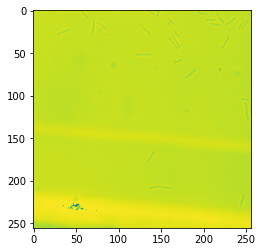

In [6]:
# DIC
image_dir = "../../Dataset/DIC_Set/DIC_Set1_Annotated"
image_type = "tif"
mask_dir = "../../Dataset/DIC_Set/DIC_Set1_Masks"
mask_type = "tif"

data_gen = DataGenerator(batch_size=BATCH_SIZE, dataset="DIC",
                         image_dir=image_dir, image_type=image_type,
                         mask_dir=mask_dir, mask_type=mask_type,
                         target_size=(256, 256), transforms=None, seed=None)

print(len(data_gen))
image_batch_0, mask_batch_0 = data_gen[0]

img1 = tf.squeeze(image_batch_0[0,...])
import matplotlib.pyplot as plt

print(img1.shape)
f = plt.figure()
plt.imshow(img1.numpy())

In [7]:
image_batch_0.shape

TensorShape([1, 256, 256, 1])

In [9]:
data_gen.data_df

,image,id,mask
0,../../Dataset/DIC_Set/DIC_Set1_Annotated\img_0...,img_000001_1,../../Dataset/DIC_Set/DIC_Set1_Masks\img_00000...
